In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

# For exploring audio files
import librosa
import librosa.display
import IPython.display as ipd

import torch
import torchaudio

import warnings
warnings.filterwarnings('ignore')

/root/jupyterlab/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('../data/VoiceSentiment/train.csv')
train

,id,path,label
0,TRAIN_0000,./train/TRAIN_0000.wav,1
1,TRAIN_0001,./train/TRAIN_0001.wav,2
2,TRAIN_0002,./train/TRAIN_0002.wav,4
3,TRAIN_0003,./train/TRAIN_0003.wav,5
4,TRAIN_0004,./train/TRAIN_0004.wav,4
...,...,...,...
4996,TRAIN_4996,./train/TRAIN_4996.wav,5
4997,TRAIN_4997,./train/TRAIN_4997.wav,0
4998,TRAIN_4998,./train/TRAIN_4998.wav,1
4999,TRAIN_4999,./train/TRAIN_4999.wav,1


In [3]:
X = train.id.groupby(train.label).count().index
Y = train.id.groupby(train.label).count()

Text(0.5, 1.0, '6 Different Sentiments')

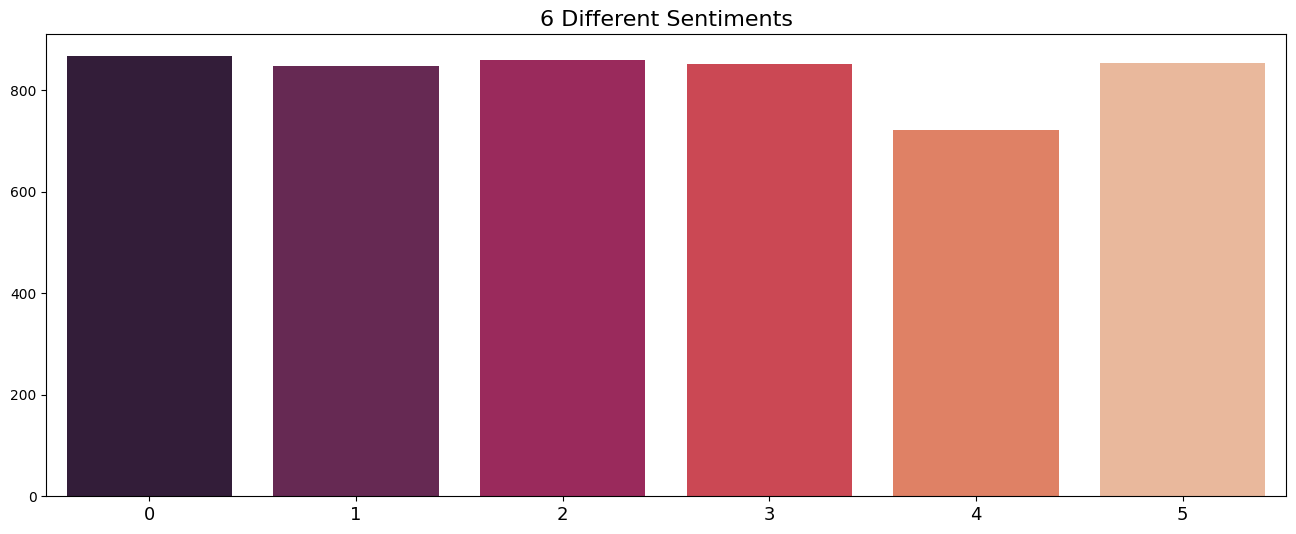

In [4]:
# === PLOT ===
plt.figure(figsize=(16, 6))
ax = sns.barplot(y=Y, x=X, palette='rocket')
plt.ylabel('', fontsize=14)
plt.xticks(fontsize=13)
plt.xlabel('')
plt.title('6 Different Sentiments', fontsize=16)

In [5]:
sentiments = [0, 1, 2, 3, 4, 5]
angry = train[train['label'] == 0].sample(1, random_state = 42)['path'].values[0]
fear = train[train['label'] == 1].sample(1, random_state = 42)['path'].values[0]
sad = train[train['label'] == 2].sample(1, random_state = 42)['path'].values[0]
disgust = train[train['label'] == 3].sample(1, random_state = 42)['path'].values[0]
neutral = train[train['label'] == 4].sample(1, random_state = 42)['path'].values[0]
happy = train[train['label'] == 5].sample(1, random_state = 42)['path'].values[0]

In [6]:
ipd.Audio(angry)

In [7]:
ipd.Audio(fear)

In [8]:
ipd.Audio(sad)

In [9]:
ipd.Audio(disgust)

In [10]:
ipd.Audio(neutral)

In [11]:
ipd.Audio(happy)

In [12]:
y_angry, sr_angry = librosa.load(angry)
audio_angry, _ = librosa.effects.trim(y_angry)

y_fear, sr_fear = librosa.load(fear)
audio_fear, _ = librosa.effects.trim(y_fear)

y_sad, sr_sad = librosa.load(sad)
audio_sad, _ = librosa.effects.trim(y_sad)

y_disgust, sr_disgust = librosa.load(disgust)
audio_disgust, _ = librosa.effects.trim(y_disgust)

y_neutral, sr_neutral = librosa.load(neutral)
audio_neutral, _ = librosa.effects.trim(y_neutral)

y_happy, sr_happy = librosa.load(happy)
audio_happy, _ = librosa.effects.trim(y_happy)

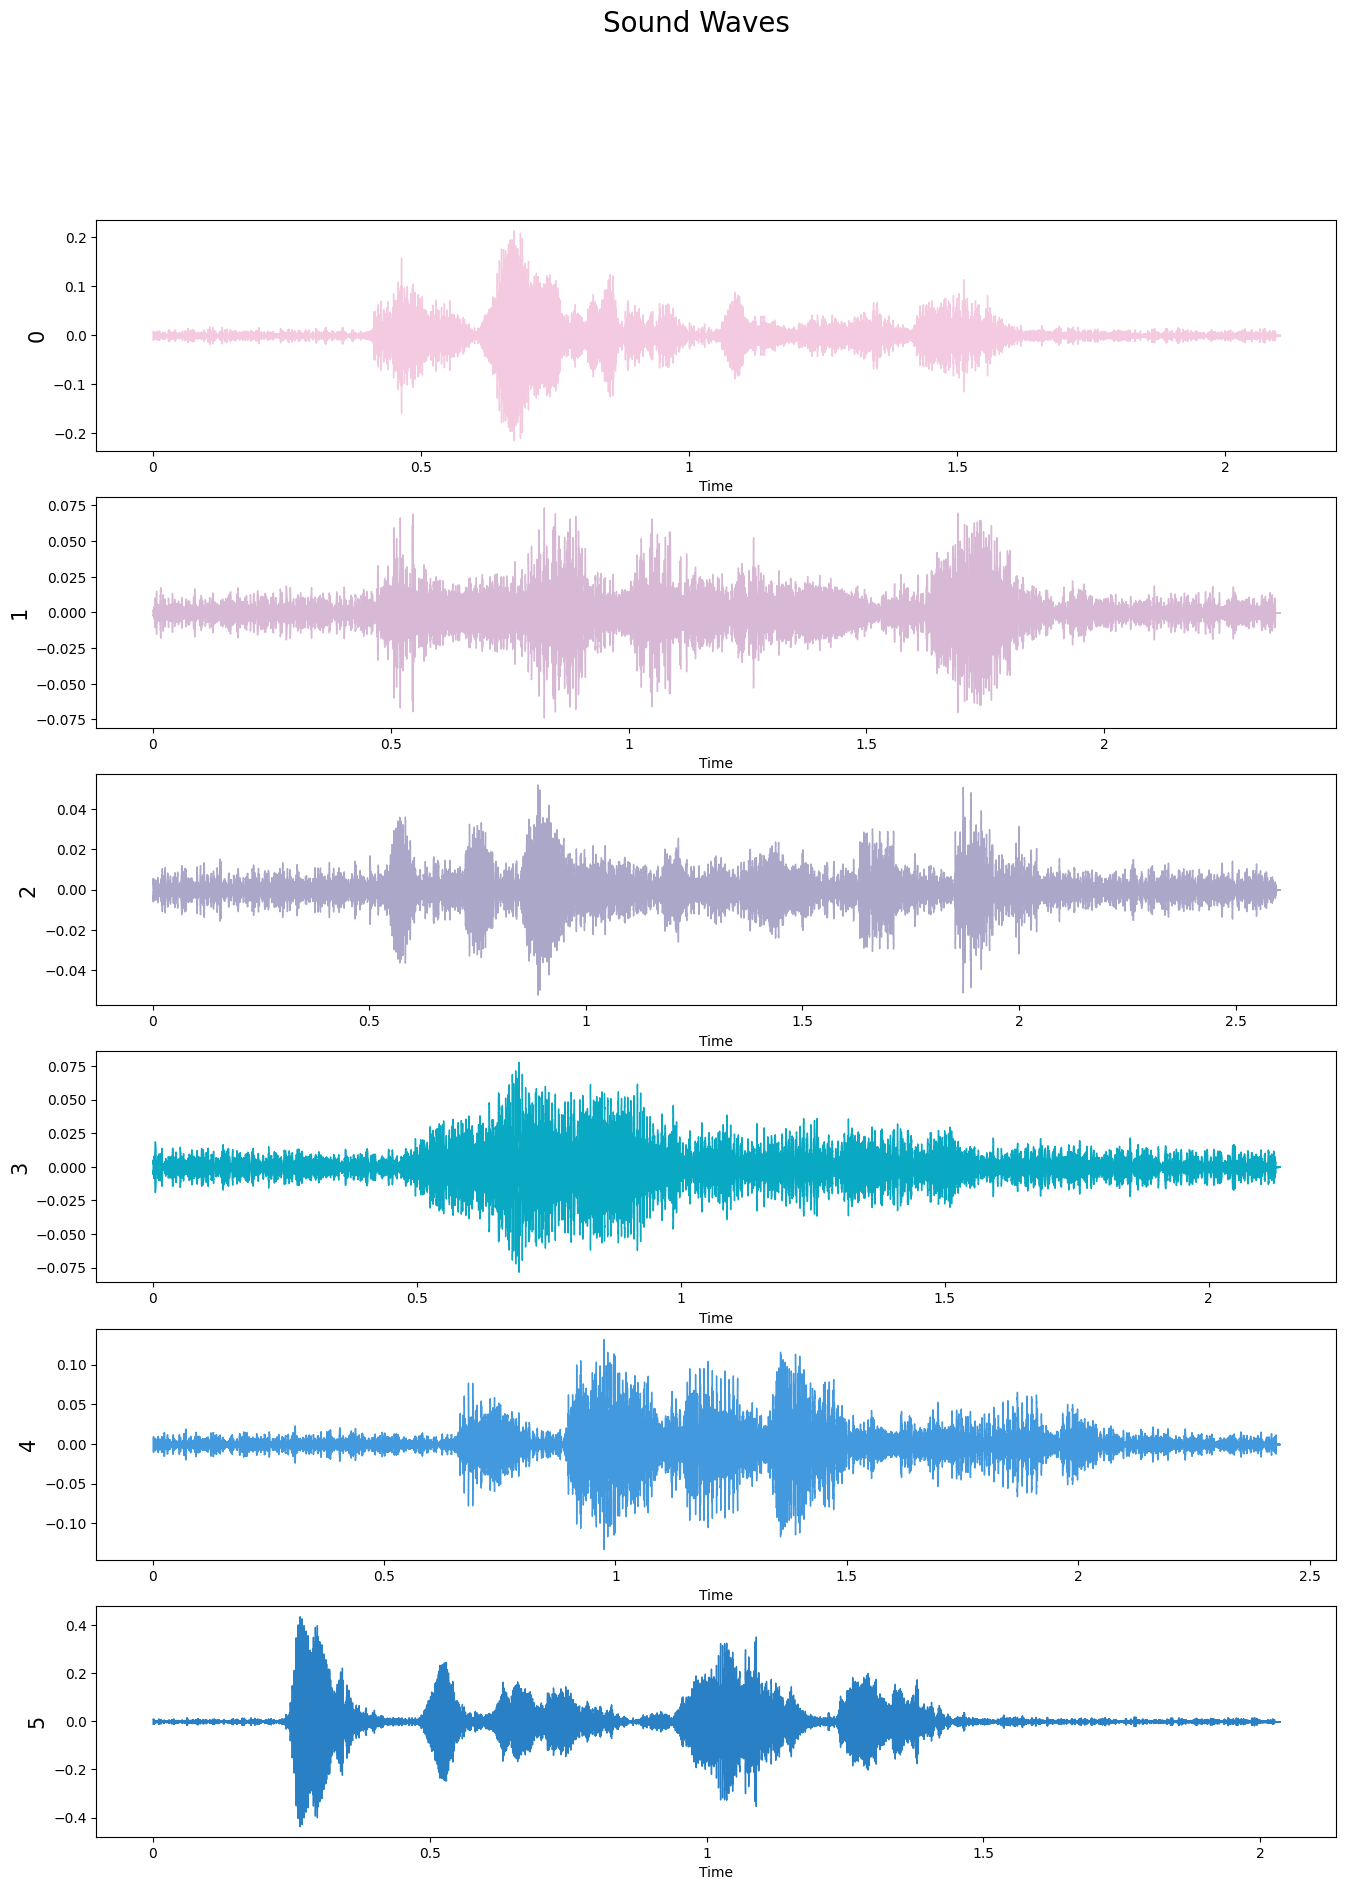

In [13]:
fig, ax = plt.subplots(6, figsize = (16, 21))
fig.suptitle('Sound Waves', fontsize=20)

librosa.display.waveshow(y = audio_angry, sr = sr_angry, color = "#F4CAE0", ax=ax[0])
librosa.display.waveshow(y = audio_fear, sr = sr_fear, color = "#D7B9D5", ax=ax[1])
librosa.display.waveshow(y = audio_sad, sr = sr_sad, color = "#ABA7C9", ax=ax[2])
librosa.display.waveshow(y = audio_disgust, sr = sr_disgust, color = "#09A8C3", ax=ax[3])
librosa.display.waveshow(y = audio_neutral, sr = sr_neutral, color = "#4399DE", ax=ax[4])
librosa.display.waveshow(y = audio_happy, sr = sr_happy, color = "#2A80C5", ax=ax[5])

for i, name in zip(range(6), sentiments):
    ax[i].set_ylabel(name, fontsize=15)

## SPECTROGRAM

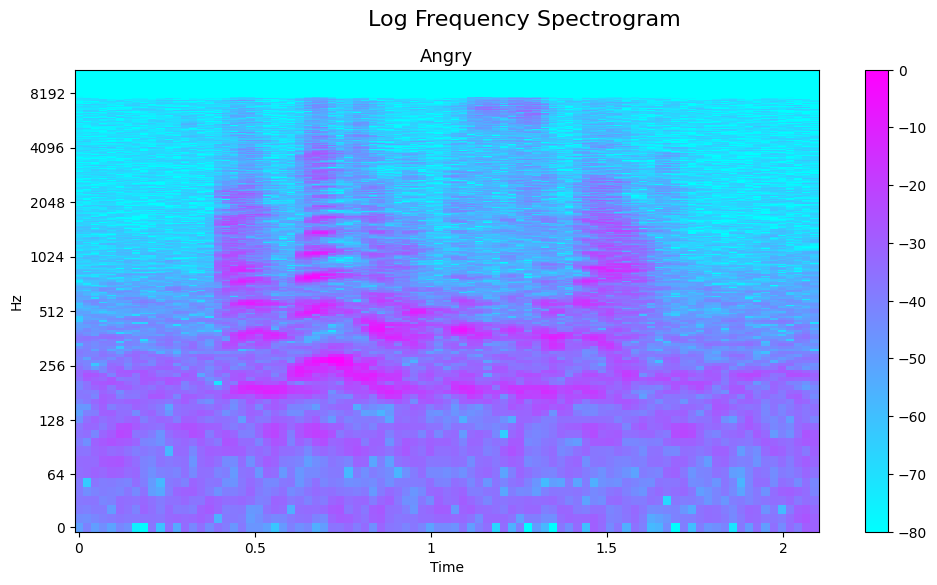

In [14]:
n_fft = 2048
hop_length=512

# Short-time Fourier transform (STFT)
D_angry = np.abs(librosa.stft(audio_angry, n_fft=n_fft, hop_length=hop_length))

# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB_angry = librosa.amplitude_to_db(D_angry, ref = np.max)

# === PLOT ===
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fig.suptitle('Log Frequency Spectrogram', fontsize=16)
img = librosa.display.specshow(DB_angry, sr = sr_angry, hop_length = hop_length,
                             x_axis = 'time', y_axis = 'log', cmap = 'cool')
ax.set_title('Angry', fontsize=13) 
plt.colorbar(img)

## RMSE

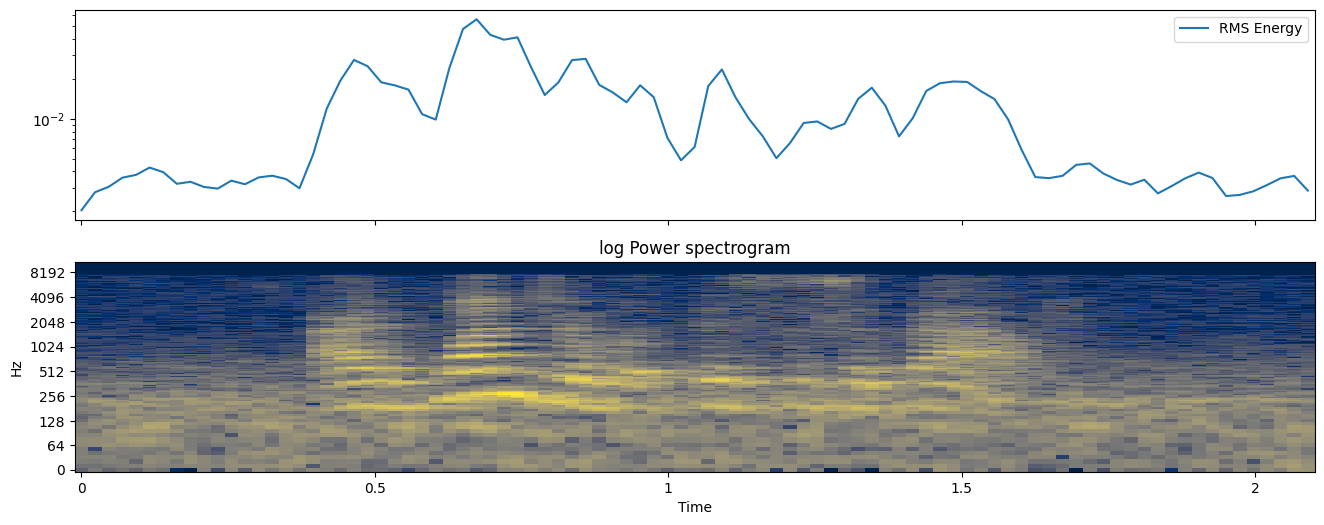

In [15]:
S, phase = librosa.magphase(librosa.stft(audio_angry))
S_db = librosa.amplitude_to_db(S, ref=np.max)

rms = librosa.feature.rms(S=S)
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(16, 6))
times = librosa.times_like(rms)

ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()

librosa.display.specshow(S_db, y_axis='log', x_axis='time', cmap= 'cividis', ax=ax[1])
ax[1].set(title='log Power spectrogram')
plt.show()

## MEL SPECTROGRAM

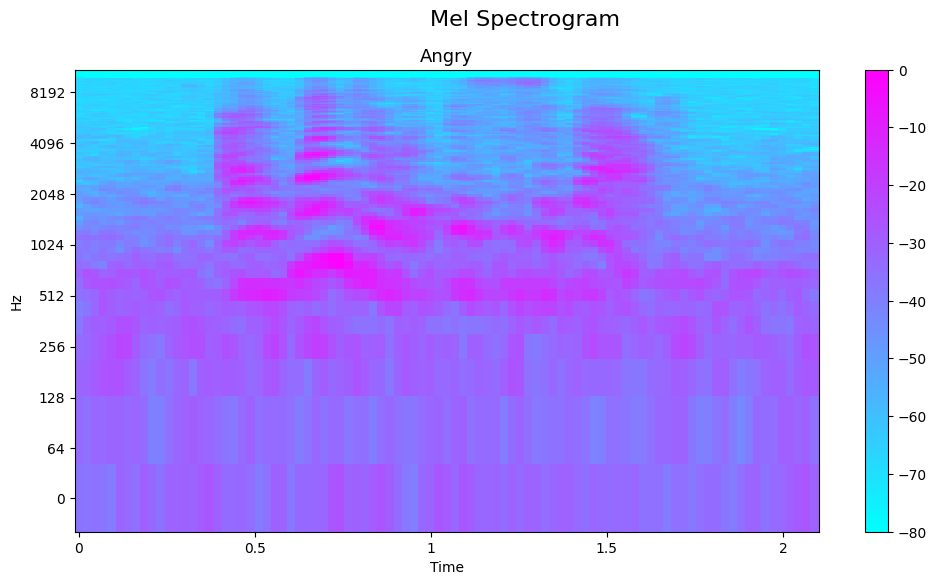

In [16]:
S_angry = librosa.feature.melspectrogram(y=audio_angry, sr=sr_angry)
S_dB = librosa.power_to_db(S_angry, ref=np.max)

# === PLOT ===
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fig.suptitle('Mel Spectrogram', fontsize=16)
img = librosa.display.specshow(S_dB, sr=sr_angry, hop_length=hop_length,
                               x_axis='time', y_axis='log', cmap='cool')
ax.set_title('Angry', fontsize=13)
plt.colorbar(img)

## Zero Crossing Rate (ZCR)

In [17]:
zero_angry = librosa.zero_crossings(audio_angry, pad=False)
zero_fear = librosa.zero_crossings(audio_fear, pad=False)
zero_sad = librosa.zero_crossings(audio_sad, pad=False)
zero_disgust = librosa.zero_crossings(audio_disgust, pad=False)
zero_neutral = librosa.zero_crossings(audio_neutral, pad=False)
zero_happy = librosa.zero_crossings(audio_happy, pad=False)
zeroSentiments = [zero_angry, zero_fear, zero_sad, zero_disgust, zero_neutral, zero_happy]

for sentiment, name in zip(zeroSentiments, sentiments):
    print(f"ZCR of {name} : {(sum(sentiment)):,}")

ZCR of 0 : 2,701
ZCR of 1 : 4,737
ZCR of 2 : 3,206
ZCR of 3 : 1,832
ZCR of 4 : 2,366
ZCR of 5 : 3,683


## Harmonic-Percussive Source Seperation (HPSS)

Text(0.5, 1.0, 'Angry')

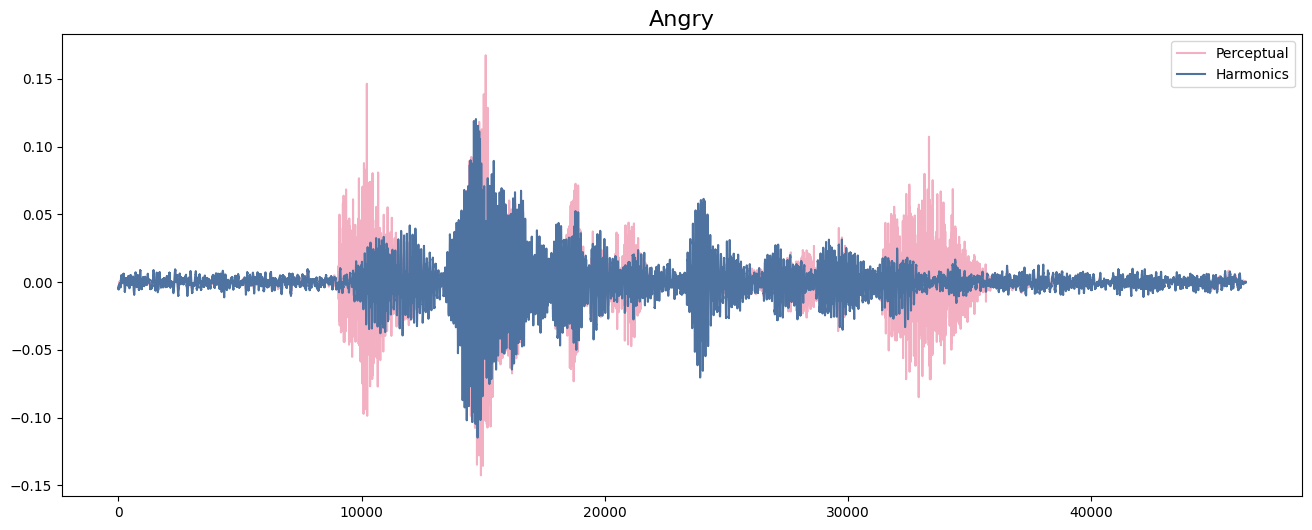

In [18]:
y_harm_angry, y_perc_angry = librosa.effects.hpss(audio_angry)
D_angry = np.abs(librosa.stft(audio_angry, n_fft=n_fft, hop_length=hop_length))
DB_angry = librosa.amplitude_to_db(D_angry, ref=np.max)

# === PLOT ===
plt.figure(figsize=(16,6))
plt.plot(y_perc_angry, color="#F3B0C3")
plt.plot(y_harm_angry, color="#4F73A1")
plt.legend(['Perceptual', 'Harmonics'])
plt.title('Angry', fontsize=16)

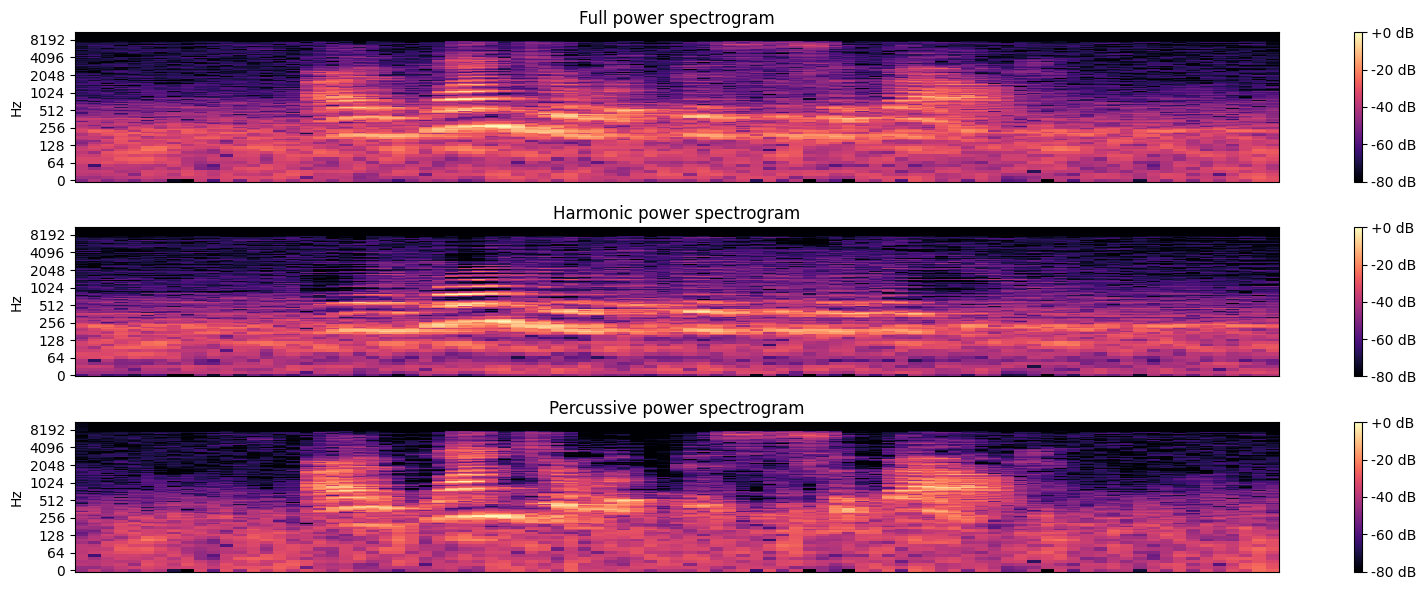

In [19]:
H, P = librosa.decompose.hpss(librosa.stft(audio_angry))
plt.figure(figsize=(16, 6))
plt.subplot(3, 1, 1)
librosa.display.specshow(DB_angry, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Full power spectrogram')

# harmonic spectrogram
plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(H), ref=np.max), y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Harmonic power spectrogram')

# percussive spectrogram
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(P), ref=np.max), y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Percussive power spectrogram')

plt.tight_layout()
plt.show()